In [84]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cPickle as pickle
from helpers import *

%matplotlib inline
sns.set_style('darkgrid')

# Load in data

In [2]:
infile = 'data/big_fitted_object.pkl'
gpm = pickle.load(open(infile, 'rb'))
dt = 1 / 30.

In [3]:
gpm.Nframe.head()

,unit,time,count,lam0,lam1
0,10,0,0,-0.061339,-0.069248
1,11,0,0,-0.820483,-1.076403
2,10,1,0,-0.063422,-0.071599
3,11,1,4,-1.389583,-0.737178
4,10,2,0,-0.064339,-0.072635


In [4]:
gpm.Xframe.head()

,X0
0,0
1,0
2,0
3,0
4,0


# Plot inferred categories as matrix

In [5]:
xi = gpm.nodes['HMM'].nodes['z'].z[1]
T, K = xi.shape
print xi.shape

(512644, 10)


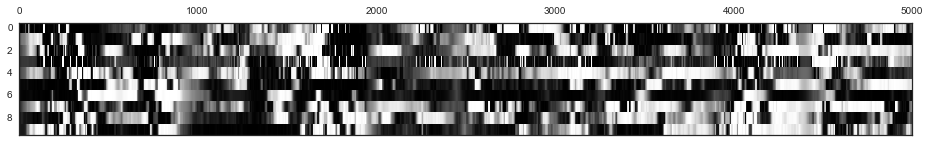

In [6]:
matshow(xi[:5000].T, vmin=0, vmax=1);

Make $\xi$ dataframe:

In [7]:
xif = pd.DataFrame(xi)
xif.columns = ['Z' + str(k) for k in range(K)]
xif.index.name = 'time'
xif = xif.reset_index()

# Posteriors for effects

## Baselines

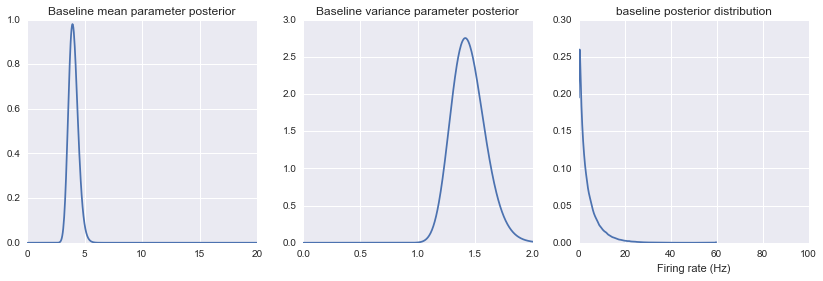

In [8]:
plt.figure(figsize=(14, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 2, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

## Regressors

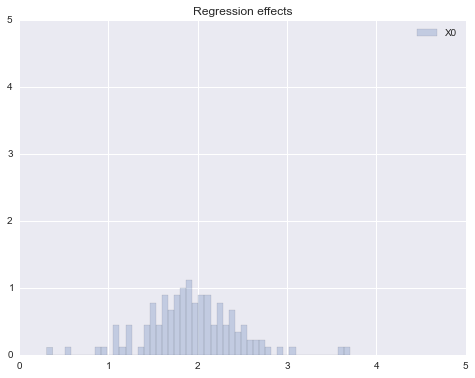

In [9]:
plt.figure(figsize=(8, 6))
inferred_means = gpm.nodes['fr_regressors'].expected_x()
R = inferred_means.shape[1]
for r in xrange(R):
    plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
plt.title('Regression effects');
plt.legend()
plt.ylim(0, 5);
plt.xlim(0, 5);

## Latent Categories

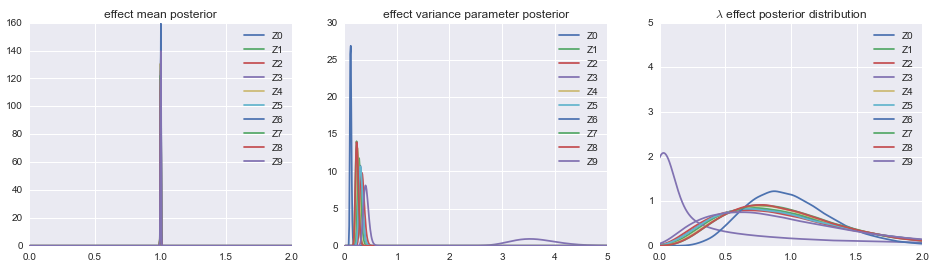

In [10]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlim(0, 2);
plt.ylim(0, 5);

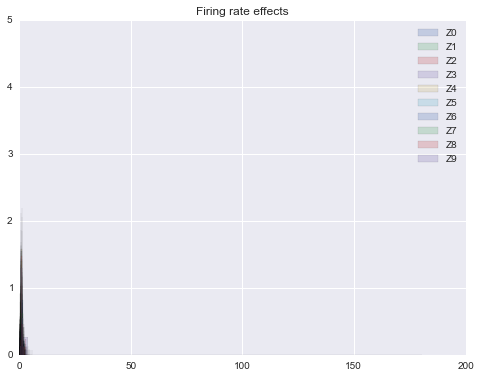

In [11]:
plt.figure(figsize=(8, 6))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');
plt.ylim(0, 5);

## Overdispersion

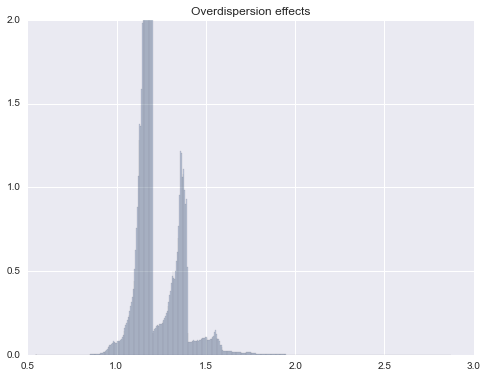

In [12]:
plt.figure(figsize=(8, 6))

inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
plt.title('Overdispersion effects');
plt.ylim(0, 2);

# Load and prepare ethogram:

Our goal here is to load the ethogram, join it to the inferred ethogram, and perform some comparisons to see if any of our discovered categories match hand-labeled categories from the ethogram.

In [13]:
ethofile = 'sql/etho.csv'
etho = pd.read_csv(ethofile)

/Users/jmxp/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [14]:
# rename some columns
etho = etho.rename(columns={'movieId': 'movie', 'frameNumber': 'frame'})
etho = frames_to_times(etho)

In [15]:
etho.head()

,frameTime,ethoCameraLabel,ethoCameraLevel,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoRoughCountLabel,...,ethoChase,ethoFlee,ethoThreaten,ethoMountedThreaten,ethoSubmit,ethoDisplace,ethoLeanAway,ethoAvoid,ethoBranchDisplay,time
0,0.0000,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0333,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0667,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0.1000,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0.1333,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [232]:
# merge labeled and inferred etho on movie and frame columns
edf = pd.merge(etho, xif, how='right')
edf.columns

Index([u'frameTime', u'ethoCameraLabel', u'ethoCameraLevel', u'ethoCameraHolding', u'ethoCameraZoomingIn', u'ethoCameraZoomingOut', u'ethoCameraTracking', u'ethoCameraPanning', u'ethoCameraSlewing', u'ethoRoughCountLabel', u'ethoRoughCountLevel', u'ethoCountNone', u'ethoLeast1', u'ethoLeast2', u'ethoLeast3', u'ethoLeast6', u'ethoLeast11', u'ethoHumanVisible', u'ethoFaceLabel', u'ethoFaceViewLevel', u'ethoFaceNone', u'ethoFaceVisible', u'ethoFaceProminent', u'ethoFaceDirect', u'ethoFaceEyeContact', u'ethoGenitalsLabel', u'ethoGenitalsViewLevel', u'ethoGenitalsNone', u'ethoGenitalsVisible', u'ethoGenitalsProminent', u'ethoGenitalsMale', u'ethoGenitalsFemale', u'ethoGenitalsBoth', u'ethoForageLabel', u'ethoForageLevel', u'ethoForage', u'ethoMassForage', u'ethoDrink', u'ethoSearch', u'ethoGraspFood', u'ethoHoldFood', u'ethoHoldInMouth', u'ethoManipulateFood', u'ethoIngestFood', u'ethoIngestFromGroom', u'ethoChew', u'ethoRetrieveFromPouch', u'ethoHeave', u'ethoAllogroom', u'ethoSolicitAllog

In [233]:
# get rid of categories that are either identifiers or have non-binary entries
edf = edf.drop(['frameTime', 'ethoCameraLabel', 'ethoFaceLabel',
                'ethoGenitalsLabel', 'ethoForageLabel', 'ethoAggressionLabel', 'time',
                'ethoCameraLevel',
                'ethoRoughCountLabel', 'ethoRoughCountLevel', 'ethoFaceViewLevel', 
                'ethoGenitalsViewLevel', 'ethoForageLevel', 'ethoAggressionLevel'], axis=1)


In [234]:
edf.head()

,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoCountNone,ethoLeast1,ethoLeast2,ethoLeast3,...,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
0,1,0,0,0,0,0,1,0,0,0,...,0.001029,0.039860,0.034572,0.037617,0.033740,0.015442,0.019248,0.031667,0.025052,0.027933
1,1,0,0,0,0,0,1,0,0,0,...,0.000153,0.117708,0.096362,0.036111,0.099480,0.026560,0.019566,0.049931,0.037210,0.059312
2,1,0,0,0,0,0,1,0,0,0,...,0.003329,0.184204,0.137946,0.062242,0.141970,0.029201,0.019374,0.069265,0.051429,0.072300
3,1,0,0,0,0,0,1,0,0,0,...,0.006572,0.235881,0.171257,0.096779,0.177964,0.030844,0.019614,0.090160,0.065216,0.081954
4,1,0,0,0,0,0,1,0,0,0,...,0.009929,0.276918,0.198862,0.127817,0.207104,0.031483,0.019878,0.110610,0.076988,0.088154


# View results:

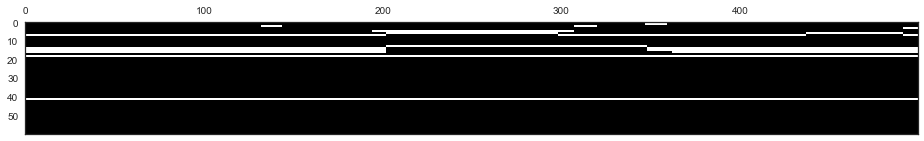

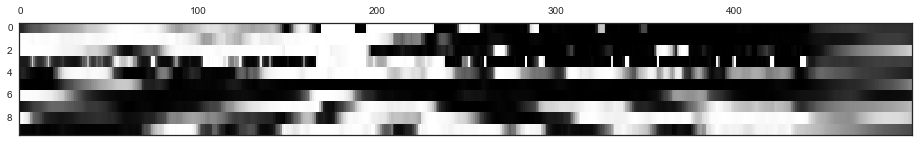

In [235]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(1500, 2000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

## Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [236]:
match = (edf.T.dot(edf) + (1 - edf.T).dot(1 - edf)) / T
mismatch = (edf.T.dot(1 - edf) + (1 - edf.T).dot(edf)) / T
overlap = np.maximum(match, mismatch)

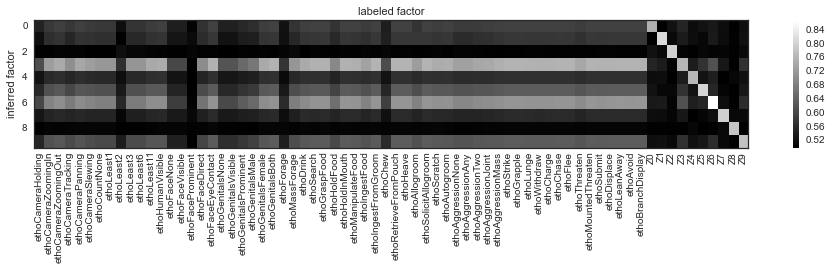

In [237]:
row_labels = edf.columns[:]
matshow(overlap.values[-K:,:]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [238]:
overlap.iloc[-K:, :]

,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoCountNone,ethoLeast1,ethoLeast2,ethoLeast3,...,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
Z0,0.549102,0.583069,0.591806,0.580268,0.591680,0.583876,0.581028,0.581028,0.520577,0.576934,...,0.755225,0.501746,0.524937,0.552942,0.517531,0.526160,0.535098,0.520215,0.501511,0.520782
Z1,0.521434,0.566841,0.573594,0.555191,0.573708,0.572212,0.568687,0.568687,0.502754,0.558589,...,0.501746,0.815459,0.514026,0.539654,0.519076,0.510645,0.537943,0.518745,0.502985,0.523230
Z2,0.504340,0.504188,0.506027,0.504806,0.504678,0.501016,0.500128,0.500128,0.523049,0.510912,...,0.524937,0.514026,0.802104,0.506078,0.501582,0.511509,0.506114,0.508485,0.502390,0.513013
Z3,0.613271,0.727267,0.746449,0.707651,0.741762,0.727918,0.718714,0.718714,0.570876,0.716206,...,0.552942,0.539654,0.506078,0.763844,0.541116,0.572481,0.618657,0.533306,0.502270,0.570284
Z4,0.527898,0.561364,0.567459,0.555587,0.566612,0.561689,0.558242,0.558242,0.521456,0.560287,...,0.517531,0.519076,0.501582,0.541116,0.766118,0.528192,0.545573,0.500128,0.510753,0.523667
Z5,0.558060,0.616110,0.626381,0.603664,0.624322,0.621185,0.616650,0.616650,0.536831,0.616135,...,0.526160,0.510645,0.511509,0.572481,0.528192,0.807710,0.556096,0.507600,0.500710,0.534635
Z6,0.602872,0.690280,0.706119,0.677741,0.702919,0.692163,0.685704,0.685704,0.558526,0.677904,...,0.535098,0.537943,0.506114,0.618657,0.545573,0.556096,0.869263,0.521005,0.503596,0.565555
Z7,0.530919,0.554491,0.557773,0.552001,0.558785,0.553763,0.553733,0.553733,0.509503,0.545287,...,0.520215,0.518745,0.508485,0.533306,0.500128,0.507600,0.521005,0.800918,0.514132,0.514215
Z8,0.502284,0.506855,0.505403,0.506965,0.508318,0.507864,0.508520,0.508520,0.501159,0.502817,...,0.501511,0.502985,0.502390,0.502270,0.510753,0.500710,0.503596,0.514132,0.784817,0.503296
Z9,0.555457,0.617599,0.626672,0.609310,0.622960,0.612339,0.607541,0.607541,0.541157,0.608769,...,0.520782,0.523230,0.513013,0.570284,0.523667,0.534635,0.565555,0.514215,0.503296,0.780221


Try using the MPM (maximizer of posterior marginals) rather than the posterior:

In [239]:
# round to 0 or 1 elementwise
medf = np.around(edf)

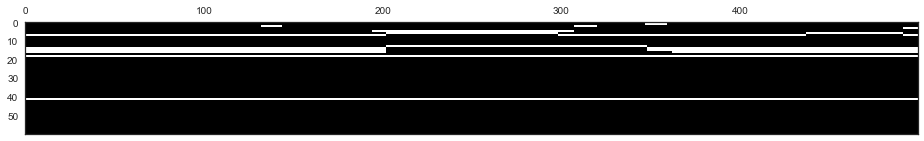

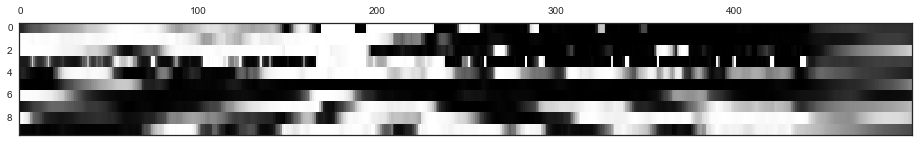

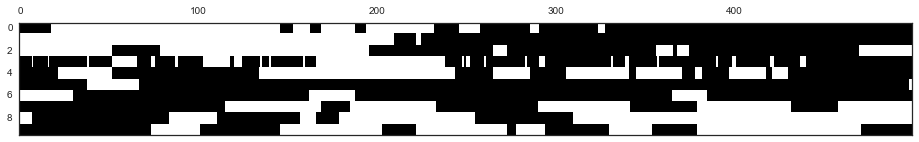

In [240]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(1500, 2000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use MPM
matshow(medf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

In [241]:
mmatch = (medf.T.dot(medf) + (1 - medf.T).dot(1 - medf)) / T
mmismatch = (medf.T.dot(1 - medf) + (1 - medf.T).dot(medf)) / T
moverlap = np.maximum(mmatch, mmismatch)

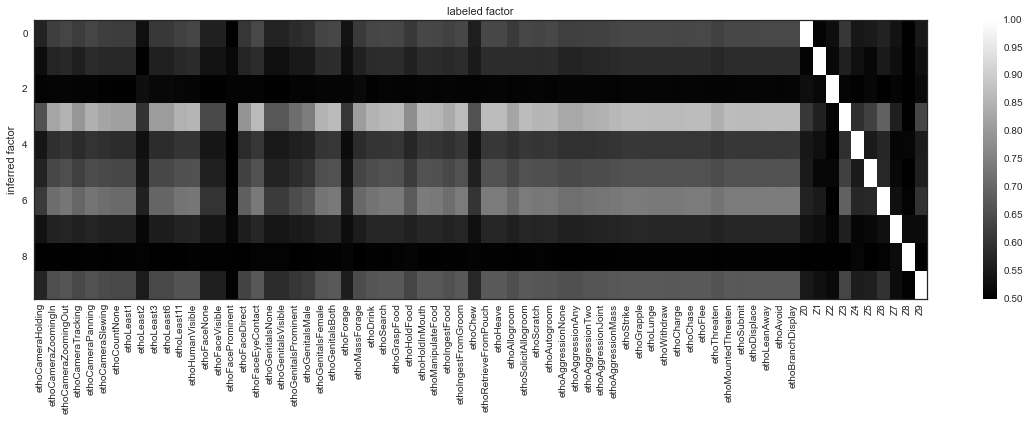

In [242]:
row_labels = medf.columns[:]
matshow(moverlap.values[-K:,:]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');
plt.gcf().set_size_inches([20, 5])

In [243]:
moverlap.iloc[-K:, :]

,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoCountNone,ethoLeast1,ethoLeast2,ethoLeast3,...,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
Z0,0.569830,0.622754,0.634899,0.617503,0.634920,0.622992,0.618667,0.618667,0.529520,0.611647,...,1.000000,0.509767,0.528534,0.609378,0.546806,0.551111,0.566742,0.538822,0.502957,0.548066
Z1,0.523726,0.574297,0.581671,0.560693,0.582344,0.580805,0.576866,0.576866,0.503753,0.565500,...,0.509767,1.000000,0.516146,0.563449,0.530052,0.515073,0.551615,0.527787,0.503084,0.533095
Z2,0.506379,0.510321,0.511445,0.509802,0.509683,0.505241,0.502946,0.502946,0.527908,0.516860,...,0.528534,0.516146,1.000000,0.511181,0.505109,0.515590,0.501106,0.510218,0.502594,0.520535
Z3,0.660002,0.823138,0.850132,0.793917,0.844231,0.824250,0.811756,0.811756,0.598000,0.805512,...,0.609378,0.563449,0.511181,1.000000,0.593205,0.626388,0.690298,0.562262,0.502626,0.635484
Z4,0.543884,0.593184,0.602219,0.586064,0.600317,0.593792,0.589163,0.589163,0.531987,0.589255,...,0.546806,0.530052,0.505109,0.593205,1.000000,0.552202,0.574738,0.511488,0.511921,0.555625
Z5,0.568781,0.639736,0.652724,0.624564,0.649878,0.645623,0.640335,0.640335,0.543775,0.639249,...,0.551111,0.515073,0.515590,0.626388,0.552202,1.000000,0.578852,0.517576,0.500230,0.560746
Z6,0.615333,0.713462,0.730698,0.699608,0.727614,0.713965,0.706890,0.706890,0.563900,0.698044,...,0.566742,0.551615,0.501106,0.690298,0.574738,0.578852,1.000000,0.531927,0.507048,0.599203
Z7,0.537133,0.567663,0.571393,0.563996,0.572233,0.565615,0.565441,0.565441,0.513965,0.556177,...,0.538822,0.527787,0.510218,0.562262,0.511488,0.517576,0.531927,1.000000,0.523193,0.525474
Z8,0.502505,0.503970,0.501711,0.503166,0.505411,0.504016,0.504393,0.504393,0.506076,0.501340,...,0.502957,0.503084,0.502594,0.502626,0.511921,0.500230,0.507048,0.523193,1.000000,0.504797
Z9,0.570870,0.653885,0.666369,0.641767,0.661545,0.646971,0.641153,0.641153,0.553402,0.642629,...,0.548066,0.533095,0.520535,0.635484,0.555625,0.560746,0.599203,0.525474,0.504797,1.000000


In [244]:
moverlap.iloc[-K:, :-K].max()

ethoCameraHolding        0.660002
ethoCameraZoomingIn      0.823138
ethoCameraZoomingOut     0.850132
ethoCameraTracking       0.793917
ethoCameraPanning        0.844231
ethoCameraSlewing        0.824250
ethoCountNone            0.811756
ethoLeast1               0.811756
ethoLeast2               0.598000
ethoLeast3               0.805512
ethoLeast6               0.805512
ethoLeast11              0.846176
ethoHumanVisible         0.854784
ethoFaceNone             0.645547
ethoFaceVisible          0.645547
ethoFaceProminent        0.516672
ethoFaceDirect           0.787334
ethoFaceEyeContact       0.865242
ethoGenitalsNone         0.670928
ethoGenitalsVisible      0.670928
ethoGenitalsProminent    0.716207
ethoGenitalsMale         0.744669
ethoGenitalsFemale       0.850194
ethoGenitalsBoth         0.866416
ethoForage               0.609251
ethoMassForage           0.807627
ethoDrink                0.850858
ethoSearch               0.863322
ethoGraspFood            0.864444
ethoHoldFood  

### What is chance overlap?

How much overlap should we expect by chance, simply based on raw statistics? Let's generate some sequences from the fitted model and look at their overlap.

In [51]:
A = gpm.nodes['HMM'].nodes['A']
pi = gpm.nodes['HMM'].nodes['pi']
dnode = gpm.nodes['HMM'].nodes['d']

In [85]:
def get_duration(mu, lam, shape, rate):
    """
    Given tuple of normal-gamma parameters, draw a duration (max = D) from
    the appropriate lognormal distribution.
    """
    while True:
        d = lognormal_from_hypers(mu, lam, shape, rate, 1)
        if (d >= 1) and (d <= gpm.D):
            break
    
    return d

In [86]:
def make_chain(A, pi, mu, lam, shape, rate):
    """
    Generate a latent state sequence. A and pi are Markov parameters. Other
    arguments specify normal-gamma hyperparameters to a lognormal duration 
    distribution.
    """

    chain = np.empty((T,))

    # initialize
    t = 0
    while t < T:
        if t == 0:
            pp = pi[1]
        else:
            pp = A[1, chain[t - 1]]

        # pick a new state
        z = stats.bernoulli.rvs(pp, size=1)

        # pick a duration
        d = get_duration(mu[z], lam[z], shape[z], rate[z]).astype('int')
        d = np.min([d, gpm.T - d])

        # fill in the next d steps of the chain
        chain[t:(t+d)] = z
        t += d
            
    return chain

In [150]:
def generate_fake_chains(nfake):
    fakechains = np.empty((T, K * nfake))

    for kk in xrange(K):

        # draw nfake transition matrices from posterior
        fakeA = np.empty(A.post.shape[:2] + (nfake,))
        for idx in xrange(fakeA.shape[1]):
            fakeA[:, idx, :] = stats.dirichlet.rvs(A.post[:, idx, kk], size=nfake).T

        # same for pi
        fakepi = np.empty(pi.post.shape[:1] + (nfake,))
        fakepi = stats.dirichlet.rvs(pi.post[..., kk], size=nfake).T

        # get poster parameters for duration distribution
        mu = dnode.parent.post_mean[:, kk]
        lam = dnode.parent.post_scaling[:, kk]
        alpha = dnode.parent.post_shape[:, kk]
        beta = dnode.parent.post_rate[:, kk]

        for idx in xrange(nfake):
            fakechains[:, kk * nfake + idx] = make_chain(fakeA[..., idx], fakepi[..., idx], mu, lam, alpha, beta)

    return fakechains

In [160]:
%%time
nfake = 100  # number of fake sequences for each chain
fchains = generate_fake_chains(nfake)

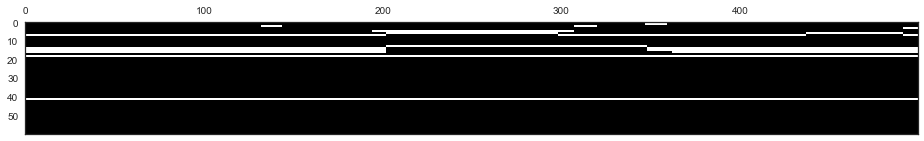

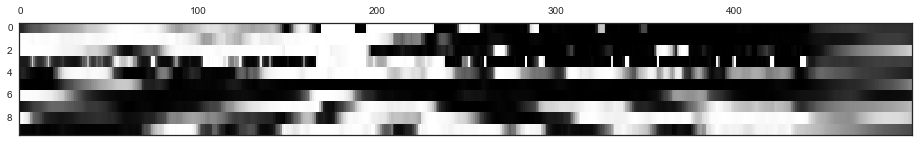

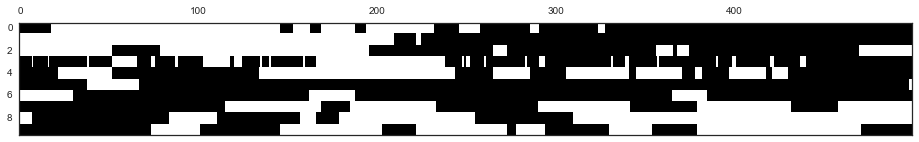

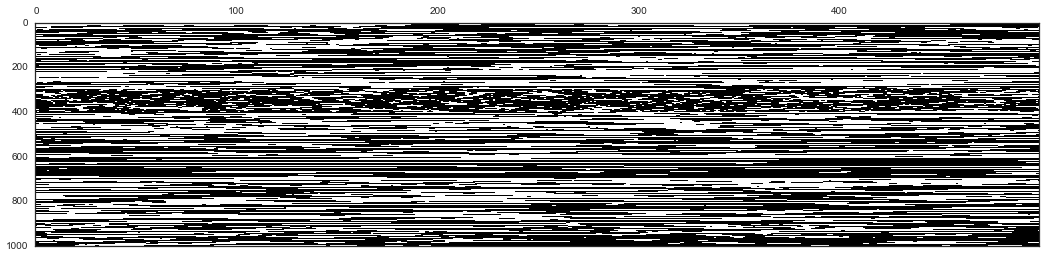

In [245]:
trng = slice(1500, 2000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use MPM
matshow(medf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use fake chains
matshow(fchains[trng].T, vmin=0, vmax=1);
plt.gcf().set_size_inches([18, 4])

Calculate overlap with actual ethogram:

In [246]:
fmatch = (edf.T.dot(fchains) + (1 - edf.T).dot(1 - fchains)) / T
fmismatch = (edf.T.dot(1 - fchains) + (1 - edf.T).dot(fchains)) / T
foverlap = np.maximum(fmatch, fmismatch)

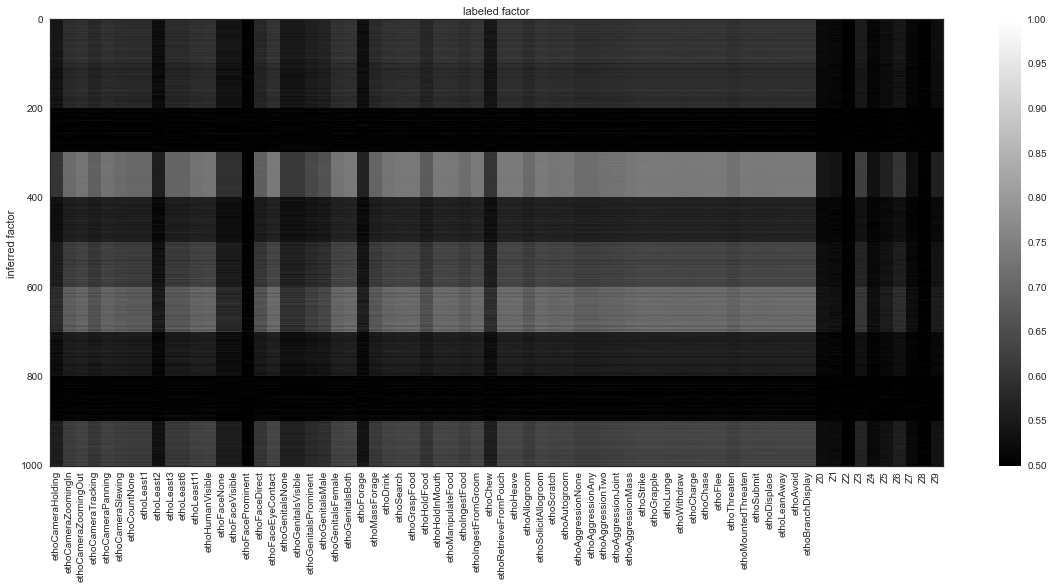

In [247]:
row_labels = edf.columns[:]
matshow(foverlap.values.T, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5);
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

plt.gcf().set_size_inches([20, 8])

In [248]:
foverlap.max(axis=1)

ethoCameraHolding       0.610402
ethoCameraZoomingIn     0.714935
ethoCameraZoomingOut    0.732807
ethoCameraTracking      0.697509
ethoCameraPanning       0.728574
ethoCameraSlewing       0.718052
ethoCountNone           0.709323
ethoLeast1              0.709323
ethoLeast2              0.572598
ethoLeast3              0.701204
ethoLeast6              0.701204
ethoLeast11             0.729350
ethoHumanVisible        0.734795
ethoFaceNone            0.602834
ethoFaceVisible         0.602834
...
ethoSubmit           0.742404
ethoDisplace         0.743469
ethoLeanAway         0.744663
ethoAvoid            0.744532
ethoBranchDisplay    0.744608
Z0                   0.549706
Z1                   0.548658
Z2                   0.514057
Z3                   0.627660
Z4                   0.541830
Z5                   0.568071
Z6                   0.609663
Z7                   0.540985
Z8                   0.514946
Z9                   0.568099
Length: 70, dtype: float64

In [249]:
foverlap.mean(axis=1)

ethoCameraHolding       0.546153
ethoCameraZoomingIn     0.592550
ethoCameraZoomingOut    0.599845
ethoCameraTracking      0.583568
ethoCameraPanning       0.598285
ethoCameraSlewing       0.592939
ethoCountNone           0.589426
ethoLeast1              0.589426
ethoLeast2              0.527018
ethoLeast3              0.586757
ethoLeast6              0.586757
ethoLeast11             0.598518
ethoHumanVisible        0.600886
ethoFaceNone            0.542731
ethoFaceVisible         0.542731
...
ethoSubmit           0.604338
ethoDisplace         0.604739
ethoLeanAway         0.605225
ethoAvoid            0.605143
ethoBranchDisplay    0.605192
Z0                   0.520392
Z1                   0.517371
Z2                   0.502962
Z3                   0.554667
Z4                   0.515150
Z5                   0.528302
Z6                   0.545916
Z7                   0.513234
Z8                   0.503064
Z9                   0.528202
Length: 70, dtype: float64

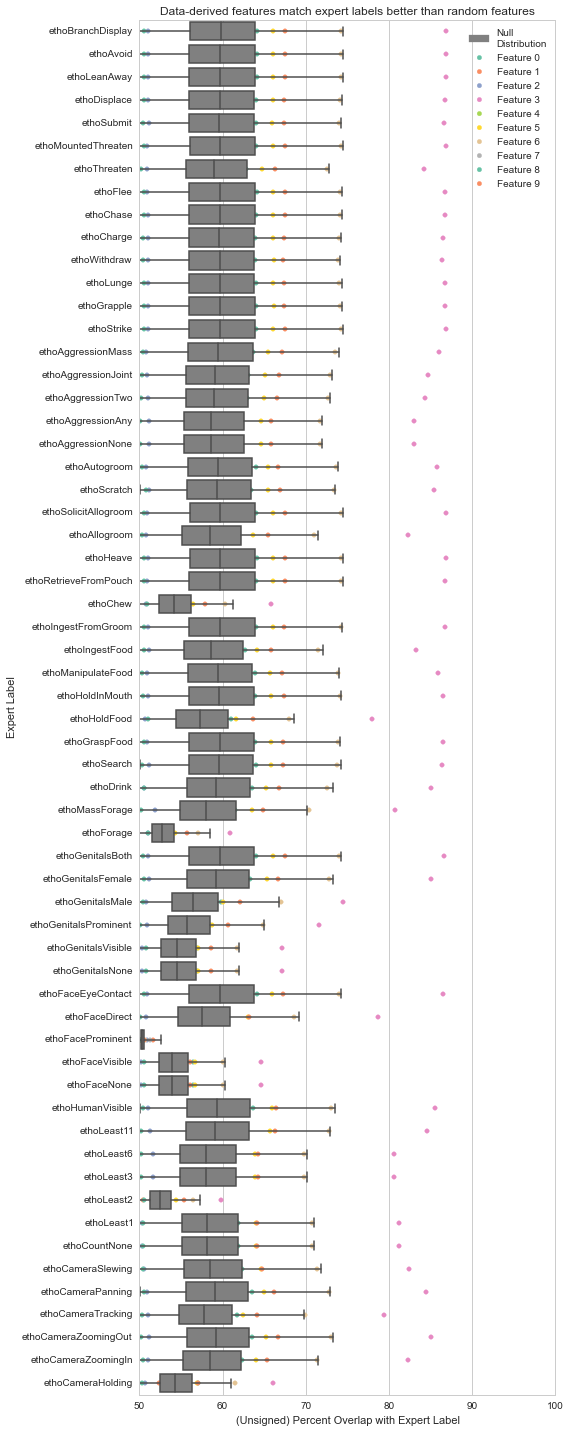

In [340]:
fov = foverlap.T.iloc[:, :-K] * 100
mov = moverlap.iloc[-K:, :-K] * 100
with sns.axes_style('whitegrid'):
    # plot data from the null distribution
    sns.boxplot(fov, vert=False, whis=1000, color='gray', label='Null\nDistribution')
    
    colors = sns.color_palette(name='Set2', n_colors=K)
    # plot data from fitted categories
    for idx in range(mov.shape[0]):
        dat = mov.iloc[idx].values
        label = 'Feature {}'.format(idx)
        plt.scatter(dat, np.arange(dat.size) + 1, color=colors[idx], label=label)
        
    plt.xlim(50, 100)
    plt.title('Data-derived features match expert labels better than random features')
    plt.xlabel('(Unsigned) Percent Overlap with Expert Label')
    plt.ylabel('Expert Label')
    plt.gcf().set_size_inches([8, 20])
    plt.legend()
    plt.gcf().tight_layout()
    plt.savefig("output/figs/overlap.svg")